# Convert yaml to requirements.txt

# Convert yaml to requirements.txt

In [1]:
# import yaml

# with open("environment.yaml") as file_handle:
#     environment_data = yaml.safe_load(file_handle)

# with open("requirements.txt", "w") as file_handle:
#     for dependency in environment_data["dependencies"][3]['pip']:
#         package_name, package_version = dependency.split("==") if "==" in dependency else dependency.split(">=")
#         file_handle.write("{} == {}\n".format(package_name, package_version))

# Test image

(720, 720, 3)


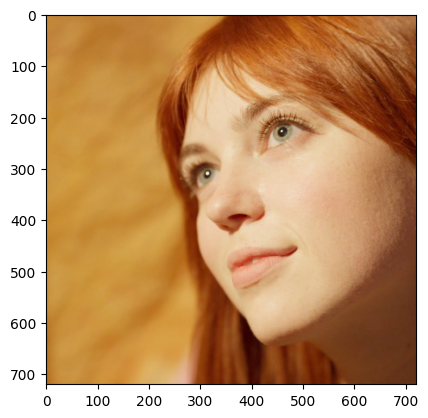

In [1]:
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt

img = Image.open("/home/ubuntu/frame_0000.png")
square_image = np.array(img)[:,:720,:]
print(square_image.shape)
plt.imshow(square_image)
square_image = Image.fromarray(square_image.astype(np.uint8))
square_image.save("/home/ubuntu/frame_0000_square.png")

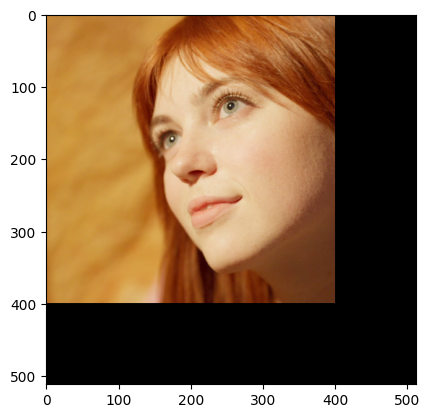

In [2]:
# create a 512 x 512 image and human occupies 400 x 400
object_size = 400
object_image = square_image.resize((object_size, object_size))
def pad_image_with_black(image, padding):
    return ImageOps.expand(image, border=padding, fill='black')

# Define the padding size (left, top, right, bottom)
padding = (0, 0, 112, 112)
img_org = pad_image_with_black(object_image, padding)
plt.imshow(img_org)

# Test DragDiffusion as API

In [3]:
import os
import cv2
import numpy as np
import gradio as gr
from copy import deepcopy
from einops import rearrange
from types import SimpleNamespace

import datetime
import PIL
from PIL import Image
from PIL.ImageOps import exif_transpose
import torch
import torch.nn.functional as F

from diffusers import DDIMScheduler, AutoencoderKL
from drag_pipeline import DragPipeline

from torchvision.utils import save_image
from pytorch_lightning import seed_everything

from drag_utils import drag_diffusion_update, drag_diffusion_update_region
from lora_utils import train_lora_api

import matplotlib.pyplot as plt
import matplotlib.patches as patches


import imageio
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F


/home/ubuntu/.conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train Lora and Save

In [4]:
image = np.array(img_org)
prompt = "a woman in CG style"
model_path = "runwayml/stable-diffusion-v1-5"
vae_path = "default"
save_lora_path = "./lora_tmp_translation"
lora_step= 200
lora_lr = 0.0002
lora_rank = 16
train_lora_api(image, prompt, model_path, vae_path, save_lora_path, lora_step, lora_lr, lora_rank)

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
/home/ubuntu/.conda/lib/python3.10/site-packages/transformers/modeling_utils.py:402: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
training LoRA: 100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


# Inference with point translation (move right 50 pixels)

In [5]:
def preprocess_image(image, device):
    image = torch.from_numpy(image).float() / 127.5 - 1 # [-1, 1]
    image = rearrange(image, "h w c -> 1 c h w")
    image = image.to(device)
    return image

def inference(source_image,
              image_with_clicks,
              mask,
              prompt,
              points,
              n_actual_inference_step,
              lam,
              n_pix_step,
              model_path,
              vae_path,
              lora_path,
              save_dir="./results"
    ):

    # initialize model
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012,
                          beta_schedule="scaled_linear", clip_sample=False,
                          set_alpha_to_one=False, steps_offset=1)
    model = DragPipeline.from_pretrained(model_path, scheduler=scheduler).to(device)
    # call this function to override unet forward function,
    # so that intermediate features are returned after forward
    model.modify_unet_forward()

    # set vae
    if vae_path != "default":
        model.vae = AutoencoderKL.from_pretrained(
            vae_path
        ).to(model.vae.device, model.vae.dtype)

    # initialize parameters
    seed = 42 # random seed used by a lot of people for unknown reason
    seed_everything(seed)

    args = SimpleNamespace()
    args.prompt = prompt
    args.points = points
    args.n_inference_step = 50
    args.n_actual_inference_step = n_actual_inference_step
    args.guidance_scale = 1.0

    args.unet_feature_idx = [2]

    args.sup_res = 256

    args.r_m = 1
    args.r_p = 3
    args.lam = lam

    args.lr = 0.01

    args.n_pix_step = n_pix_step
    print(args)
    full_h, full_w = source_image.shape[:2]

    source_image = preprocess_image(source_image, device)
    image_with_clicks = preprocess_image(image_with_clicks, device)

    # set lora
    if lora_path == "":
        print("applying default parameters")
        model.unet.set_default_attn_processor()
    else:
        print("applying lora: " + lora_path)
        model.unet.load_attn_procs(lora_path)

    # invert the source image
    # the latent code resolution is too small, only 64*64
    invert_code = model.invert(source_image,
                               prompt,
                               guidance_scale=args.guidance_scale,
                               num_inference_steps=args.n_inference_step,
                               num_actual_inference_steps=n_actual_inference_step)

    mask = torch.from_numpy(mask).float() / 255.
    mask[mask > 0.0] = 1.0
    mask = rearrange(mask, "h w -> 1 1 h w").cuda()
    mask = F.interpolate(mask, (args.sup_res, args.sup_res), mode="nearest")

    handle_points = []
    target_points = []
    # here, the point is in x,y coordinate
    for idx, point in enumerate(points):
        cur_point = torch.tensor([point[1] / full_h, point[0] / full_w]) * args.sup_res
        cur_point = torch.round(cur_point)
        if idx % 2 == 0:
            handle_points.append(cur_point)
        else:
            target_points.append(cur_point)
    print('handle points:', handle_points)
    print('target points:', target_points)

    init_code = invert_code
    model.scheduler.set_timesteps(args.n_inference_step)
    t = model.scheduler.timesteps[args.n_inference_step - n_actual_inference_step]

    # feature shape: [1280,16,16], [1280,32,32], [640,64,64], [320,64,64]
    # update according to the given supervision
    updated_init_code, updated_text_emb = drag_diffusion_update(model, init_code, t,
        handle_points, target_points, mask, args)

    # inference the synthesized image
    gen_image = model(prompt,
        prompt_embeds=updated_text_emb,
        latents=updated_init_code,
        guidance_scale=1.0,
        num_inference_steps=args.n_inference_step,
        num_actual_inference_steps=n_actual_inference_step
        )

    # save the original image, user editing instructions, synthesized image
    save_result = torch.cat([
        source_image * 0.5 + 0.5,
        torch.ones((1,3,512,25)).cuda(),
        image_with_clicks * 0.5 + 0.5,
        torch.ones((1,3,512,25)).cuda(),
        gen_image[0:1]
    ], dim=-1)

    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    save_prefix = datetime.datetime.now().strftime("%Y-%m-%d-%H%M-%S")
    save_image(save_result, os.path.join(save_dir, save_prefix + '.png'))

    out_image = gen_image.cpu().permute(0, 2, 3, 1).numpy()[0]
    out_image = (out_image * 255).astype(np.uint8)
    return out_image

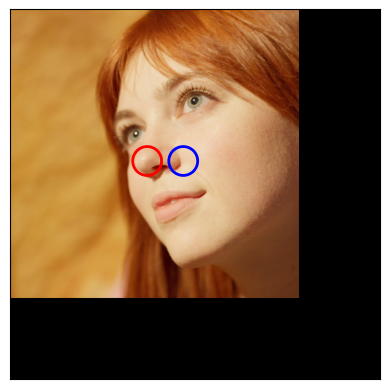

In [6]:
# Center coordinates of the circle
red_center = (190, 210)
blue_center = (240, 210)
# Radius of the circle
radius = 20

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(img_org)

# Create a circle patch
red_circle = patches.Circle(red_center, radius, fill=False, color='red', linewidth=2)
blue_circle = patches.Circle(blue_center, radius, fill=False, color='blue', linewidth=2)


# Add the circle patch to the axis
ax.add_patch(red_circle)
ax.add_patch(blue_circle)

# Set axis limits to match the image dimensions
ax.set_xlim(0, img_org.size[1])
ax.set_ylim(img_org.size[0], 0)

# Remove axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Global seed set to 42


namespace(prompt='a woman in CG style', points=[[190, 210], [240, 210]], n_inference_step=50, n_actual_inference_step=40, guidance_scale=1.0, unet_feature_idx=[2], sup_res=256, r_m=1, r_p=3, lam=0.1, lr=0.01, n_pix_step=50)
applying lora: ./lora_tmp_translation
input text embeddings : torch.Size([1, 77, 768])
latents shape:  torch.Size([1, 4, 64, 64])
Valid timesteps:  tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 981])


DDIM Inversion: 100%|██████████| 50/50 [00:03<00:00, 13.14it/s]


handle points: [tensor([105.,  95.])]
target points: [tensor([105., 120.])]
torch.Size([1, 640, 64, 64])
torch.Size([1, 640, 64, 64])
loss total=4.713085
torch.Size([1, 640, 64, 64])
new handle points [tensor([105.,  95.])]
loss total=4.715137
torch.Size([1, 640, 64, 64])
new handle points [tensor([105.,  95.])]
loss total=4.715390
torch.Size([1, 640, 64, 64])
new handle points [tensor([105.,  95.])]
loss total=4.714156
torch.Size([1, 640, 64, 64])
new handle points [tensor([106.,  96.])]
loss total=4.257027
torch.Size([1, 640, 64, 64])
new handle points [tensor([107.,  97.])]
loss total=3.876771
torch.Size([1, 640, 64, 64])
new handle points [tensor([106., 100.])]
loss total=3.640077
torch.Size([1, 640, 64, 64])
new handle points [tensor([105., 103.])]
loss total=3.689292
torch.Size([1, 640, 64, 64])
new handle points [tensor([107., 106.])]
loss total=3.293645
torch.Size([1, 640, 64, 64])
new handle points [tensor([106., 109.])]
loss total=3.484468
torch.Size([1, 640, 64, 64])
new han

DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.27it/s]


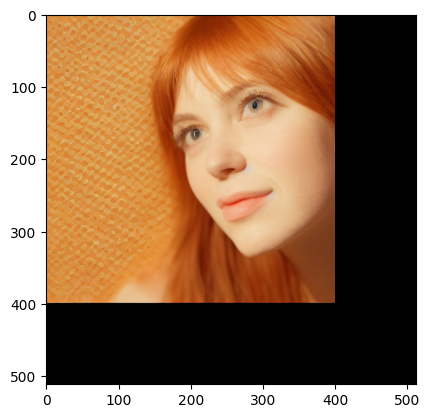

In [7]:
source_image = np.array(img_org)
image_with_clicks = np.array(img_org)
mask = np.ones((512,512))
prompt = "a woman in CG style"
points = [[190, 210], [240, 210]]
n_actual_inference_step = 40
lam = 0.1
n_pix_step = 50
model_path = "runwayml/stable-diffusion-v1-5"
vae_path = "default"
lora_path = "./lora_tmp_translation"
save_dir="./results"

output_image = inference(source_image,
              image_with_clicks,
              mask,
              prompt,
              points,
              n_actual_inference_step,
              lam,
              n_pix_step,
              model_path,
              vae_path,
              lora_path,
              save_dir
    )
plt.imshow(output_image)
plt.show()

# Inference with region translation (move right 50 pixels)

In [10]:
def preprocess_image(image, device):
    image = torch.from_numpy(image).float() / 127.5 - 1 # [-1, 1]
    image = rearrange(image, "h w c -> 1 c h w")
    image = image.to(device)
    return image

def inference_region(source_image,
              image_with_clicks,
              mask,
              prompt,
              points,
              n_actual_inference_step,
              lam,
              n_pix_step,
              model_path,
              vae_path,
              lora_path,
              save_dir="./results"
    ):

    # initialize model
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012,
                          beta_schedule="scaled_linear", clip_sample=False,
                          set_alpha_to_one=False, steps_offset=1)
    model = DragPipeline.from_pretrained(model_path, scheduler=scheduler).to(device)
    # call this function to override unet forward function,
    # so that intermediate features are returned after forward
    model.modify_unet_forward()

    # set vae
    if vae_path != "default":
        model.vae = AutoencoderKL.from_pretrained(
            vae_path
        ).to(model.vae.device, model.vae.dtype)

    # initialize parameters
    seed = 42 # random seed used by a lot of people for unknown reason
    seed_everything(seed)

    args = SimpleNamespace()
    args.prompt = prompt
    args.points = points
    args.n_inference_step = 50
    args.n_actual_inference_step = n_actual_inference_step
    args.guidance_scale = 1.0

    args.unet_feature_idx = [2]

    args.sup_res = 256

    args.r_m = 99
    args.r_p = 3
    args.lam = lam

    args.lr = 0.01

    args.n_pix_step = n_pix_step
    print(args)
    full_h, full_w = source_image.shape[:2]

    source_image = preprocess_image(source_image, device)
    image_with_clicks = preprocess_image(image_with_clicks, device)

    # set lora
    if lora_path == "":
        print("applying default parameters")
        model.unet.set_default_attn_processor()
    else:
        print("applying lora: " + lora_path)
        model.unet.load_attn_procs(lora_path)

    # invert the source image
    # the latent code resolution is too small, only 64*64
    invert_code = model.invert(source_image,
                               prompt,
                               guidance_scale=args.guidance_scale,
                               num_inference_steps=args.n_inference_step,
                               num_actual_inference_steps=n_actual_inference_step)

    mask = torch.from_numpy(mask).float() / 255.
    mask[mask > 0.0] = 1.0
    mask = rearrange(mask, "h w -> 1 1 h w").cuda()
    mask = F.interpolate(mask, (args.sup_res, args.sup_res), mode="nearest")

    handle_points = []
    target_points = []
    # here, the point is in x,y coordinate
    for idx, point in enumerate(points):
        cur_point = torch.tensor([point[1] / full_h, point[0] / full_w]) * args.sup_res
        cur_point = torch.round(cur_point)
        if idx % 2 == 0:
            handle_points.append(cur_point)
        else:
            target_points.append(cur_point)
    print('handle points:', handle_points)
    print('target points:', target_points)

    init_code = invert_code
    model.scheduler.set_timesteps(args.n_inference_step)
    t = model.scheduler.timesteps[args.n_inference_step - n_actual_inference_step]

    # feature shape: [1280,16,16], [1280,32,32], [640,64,64], [320,64,64]
    # update according to the given supervision
    updated_init_code, updated_text_emb = drag_diffusion_update_region(model, init_code, t,
        handle_points, target_points, mask, args)

    # inference the synthesized image
    gen_image = model(prompt,
        prompt_embeds=updated_text_emb,
        latents=updated_init_code,
        guidance_scale=1.0,
        num_inference_steps=args.n_inference_step,
        num_actual_inference_steps=n_actual_inference_step
        )

    # save the original image, user editing instructions, synthesized image
    save_result = torch.cat([
        source_image * 0.5 + 0.5,
        torch.ones((1,3,512,25)).cuda(),
        image_with_clicks * 0.5 + 0.5,
        torch.ones((1,3,512,25)).cuda(),
        gen_image[0:1]
    ], dim=-1)

    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    save_prefix = datetime.datetime.now().strftime("%Y-%m-%d-%H%M-%S")
    save_image(save_result, os.path.join(save_dir, save_prefix + '.png'))

    out_image = gen_image.cpu().permute(0, 2, 3, 1).numpy()[0]
    out_image = (out_image * 255).astype(np.uint8)
    return out_image

In [11]:
source_image = np.array(img_org)
image_with_clicks = np.array(img_org)
mask = np.ones((512,512))
prompt = "a woman in CG style"
points = [[200, 200], [250, 200]]
n_actual_inference_step = 40
lam = 0.1
n_pix_step = 50
model_path = "runwayml/stable-diffusion-v1-5"
vae_path = "default"
lora_path = "./lora_tmp_translation"
save_dir="./results"

output_image = inference_region(source_image,
              image_with_clicks,
              mask,
              prompt,
              points,
              n_actual_inference_step,
              lam,
              n_pix_step,
              model_path,
              vae_path,
              lora_path,
              save_dir
    )
plt.imshow(output_image)
plt.show()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Global seed set to 42


namespace(prompt='a woman in CG style', points=[[200, 200], [250, 200]], n_inference_step=50, n_actual_inference_step=40, guidance_scale=1.0, unet_feature_idx=[2], sup_res=256, r_m=99, r_p=3, lam=0.1, lr=0.01, n_pix_step=50)
applying lora: ./lora_tmp_translation
input text embeddings : torch.Size([1, 77, 768])
latents shape:  torch.Size([1, 4, 64, 64])
Valid timesteps:  tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 981])


DDIM Inversion: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


handle points: [tensor([100., 100.])]
target points: [tensor([100., 125.])]
torch.Size([1, 640, 64, 64])
torch.Size([1, 640, 64, 64])
loss total=8761.483398
torch.Size([1, 640, 64, 64])
new handle points [tensor([100., 100.])]
loss total=8761.553711
torch.Size([1, 640, 64, 64])
new handle points [tensor([100., 100.])]
loss total=8761.788086


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 lora_path = "./lora_tmp_translation"                                                        │
│   12 save_dir="./results"                                                                        │
│   13                                                                                             │
│ ❱ 14 output_image = inference_region(source_image,                                               │
│   15 │   │   │     image_with_clicks,                                                            │
│   16 │   │   │     mask,                                                                         │
│   17 │   │   │     prompt,                                                                       │
│                                                                                                  │
│ in inference_region:105                                                                          │
│                                                                                                  │
│   102 │                                                                                          │
│   103 │   # feature shape: [1280,16,16], [1280,32,32], [640,64,64], [320,64,64]                  │
│   104 │   # update according to the given supervision                                            │
│ ❱ 105 │   updated_init_code, updated_text_emb = drag_diffusion_update_region(model, init_code,   │
│   106 │   │   handle_points, target_points, mask, args)                                          │
│   107 │                                                                                          │
│   108 │   # inference the synthesized image                                                      │
│                                                                                                  │
│ /home/ubuntu/DragDiffusion/drag_utils.py:187 in drag_diffusion_update_region                     │
│                                                                                                  │
│   184 │   │   │   loss += args.lam * ((x_prev_updated-x_prev_0)*(1.0-interp_mask)).abs().sum()   │
│   185 │   │   │   print('loss total=%f'%(loss.item()))                                           │
│   186 │   │                                                                                      │
│ ❱ 187 │   │   scaler.scale(loss).backward()                                                      │
│   188 │   │   scaler.step(optimizer)                                                             │
│   189 │   │   scaler.update()                                                                    │
│   190 │   │   optimizer.zero_grad()                                                              │
│                                                                                                  │
│ /home/ubuntu/.conda/lib/python3.10/site-packages/torch/_tensor.py:487 in backward                │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                     